In [1]:
import numpy as np
import yfinance as yf
import fredpy as fp
import math
from matplotlib import animation as ani 
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
from datetime import datetime as dt
import plotly.express as px

/Users/benjamin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
fp.api_key = 'enter your fredpy api key here'  

In [3]:
start = '1990-01-01'
end = '2022-12-4'

In [4]:
def get_curve(*series_names, start = str, end = str):
    ###input FRED series names in order of maturity###
    #get yields for each maturity
    yields = {series_name : (pd.Series({k: v for k, v in fp.series(series_name).data.items() if not math.isnan(v)})) for series_name in series_names}
    #get dates
    dates = pd.date_range(start,end)
    #assign each date to yields for each maturity
    curve={}
    for date in dates:
        #build x and y axis
        rate = []
        remove_x = []
        x_axis = [1/12,3/12,6/12,1,2,3,5,7,10,20,30]
        #fill y axis and find index of elements to remove from x axis, if any
        for series in yields.values():
            try:
                rate.append(series[date])
            except KeyError:
                remove_x.append(len(rate))
                rate.append(np.nan)
        #remove elements from x axis
        for x_item in sorted(remove_x, reverse = True):
           del x_axis[x_item]
        #remove nans from y axis
        rate = [ele for ele in rate if not (math.isnan(ele)) == True]
        #fill curve with x and y axis
        curve[date] = [x_axis, rate]
        if curve[date] == [[], []]:
            del curve[date]
    return curve

In [5]:
curve = get_curve('DGS1MO','DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30', start = start, end = end)

In [6]:
sp = yf.download('^GSPC', start, end)['Close']

[*********************100%***********************]  1 of 1 completed


In [7]:
for date in list(set(sp.index).symmetric_difference(set(list(curve.keys())))):
    if date in curve:
        del curve[date]
    else:
        del sp[date]

In [8]:
keys = list(curve.keys())

In [9]:
sp.index = range(len(sp))

In [10]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 12

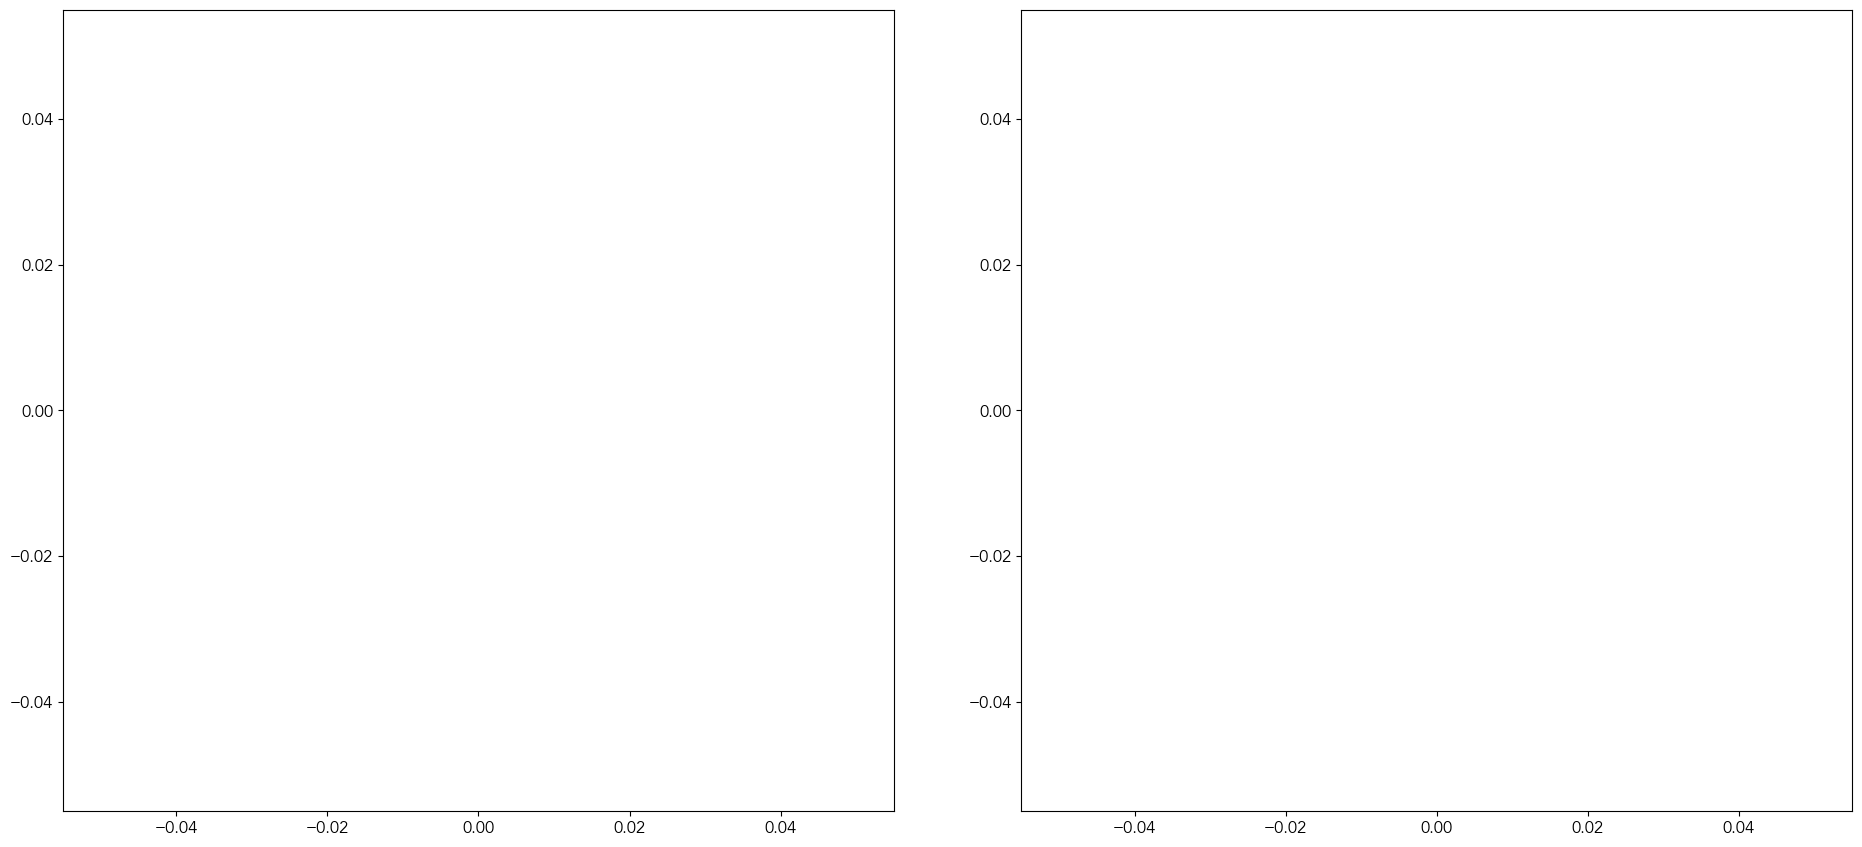

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (20,10))
fig.tight_layout(pad = 5)
line1, = ax[0].plot([],[], 'o-', lw = 2, color = 'blue')
line2, = ax[1].plot([],[], lw = 2, color = 'red')
sp_x = []
sp_y = []

In [12]:

def animate_curve(i):
    ax[0].set_xlabel('Maturity')
    ax[0].set_xlim(0, 30)
    ax[0].set_ylabel('Yield')
    ax[0].set_ylim(0, max(list(map(lambda x : max(curve[x][1]), keys))) * 1.5)
    fig.suptitle(dt.strftime(keys[i], '%Y-%m-%d'))
    x = curve[keys[i]][0]
    y = curve[keys[i]][1]
    line1.set_data(x,y)
    return line1,


In [13]:
def animate_sp(i):
    ax[1].set_xlabel('Day')
    ax[1].set_xlim(0, sp.index[i])
    ax[1].set_ylabel('Price')
    ax[1].set_ylim(min(sp)*0.9, max(sp)*1.2)
    ax[1].set_yscale('log')
    sp_x.append(sp.index[i])
    sp_y.append(sp[i])
    line2.set_data(sp_x,sp_y)
    return line2, 

In [14]:
def animate_all(i):
    animate_sp(i)
    animate_curve(i)


In [15]:
anim = ani.FuncAnimation(fig, animate_all, frames = len(curve), interval = 12)
anim.save('gfc.mp4', 'ffmpeg', 60)

/var/folders/0g/0pyvp71x00d07s_b28p42ctc0000gn/T/ipykernel_45322/3422226874.py:3: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[1].set_xlim(0, sp.index[i])


In [38]:
spread = []
for date in keys:
    if 3 and 10 in curve[date][0]:
        index3 = curve[date][0].index(3)
        index10 = curve[date][0].index(10)
        spread.append(curve[date][1][index3] - curve[date][1][index10])
spread = pd.Series(spread, keys)

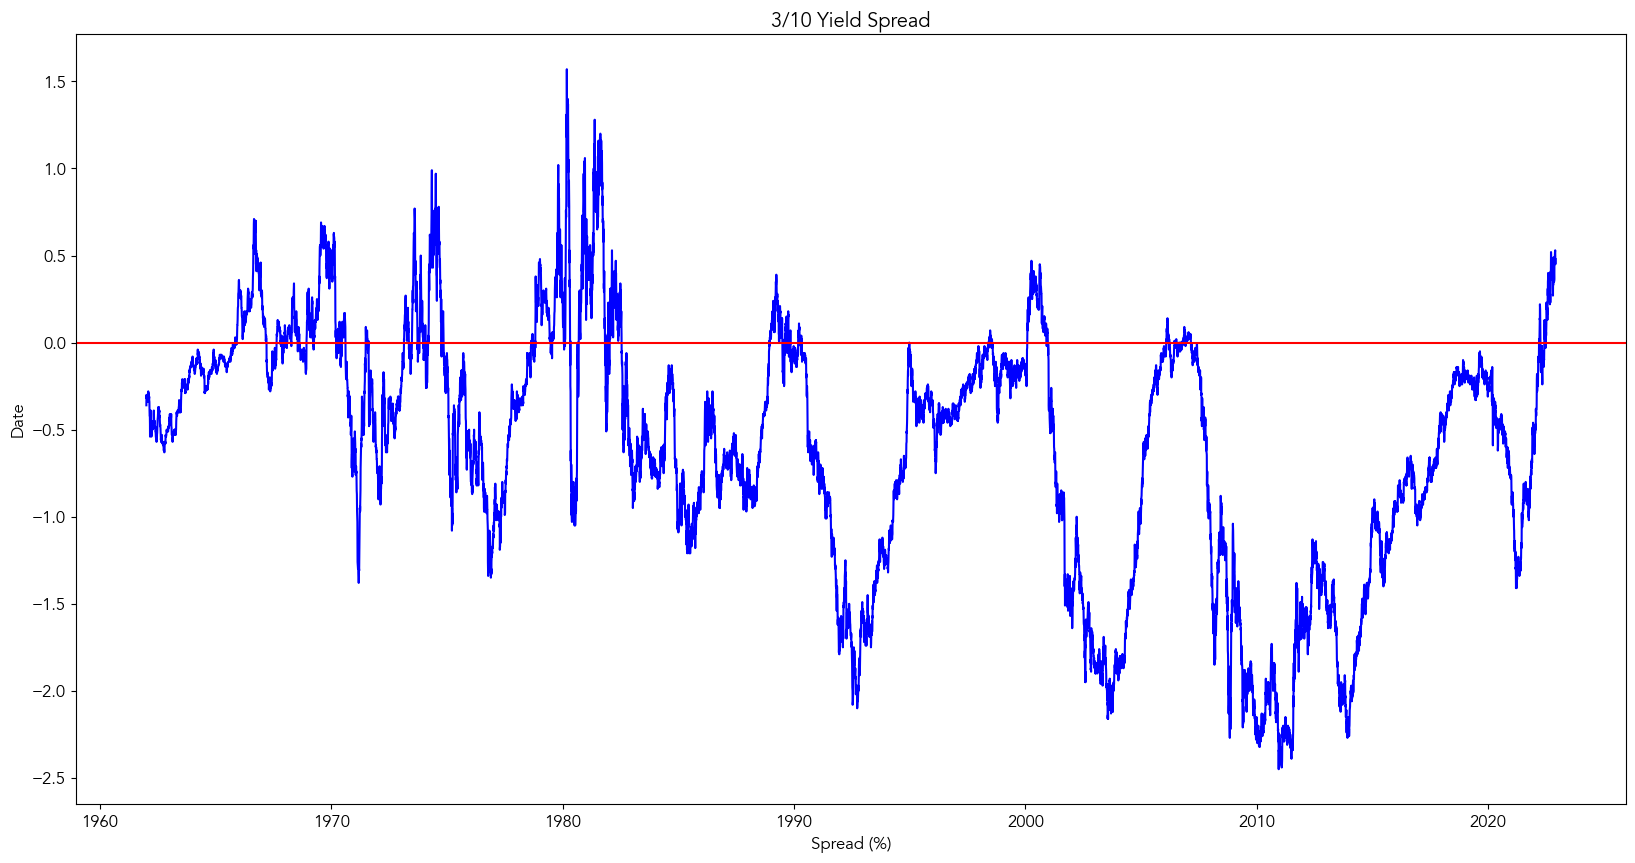

In [39]:
fig = plt.figure(figsize = (20,10))
plt.title('3/10 Yield Spread')
plt.xlabel('Spread (%)')
plt.ylabel('Date')
plt.plot(spread, color = 'blue')
plt.axhline(0, color = 'red')
plt.show()

In [18]:
fig = px.line(x = spread.index, y = spread, labels = dict(x = 'date', y = 'spread'), title = '3/10 Yield Spread') 
fig.show()